# I. Preparation

In [1]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [2]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [3]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [4]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [5]:
table = 7

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (30, 50)

# Frequency range from which to collect Gaussians
bn = (38,47)

## 3. Parameters that should stay fixed

In [6]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [7]:
## Read EEG, calculate PSD (Welch), fit FOOOF

# Initialize array per target, grand average over subjects, days, trials and channels
total_powers_50 = np.empty((0, int(nperseg//2)+1), float)
total_powers_55 = np.empty((0, int(nperseg//2)+1), float)
total_powers_60 = np.empty((0, int(nperseg//2)+1), float)
total_powers_65 = np.empty((0, int(nperseg//2)+1), float)
total_powers_210 = np.empty((0, int(nperseg//2)+1), float)
total_powers_215 = np.empty((0, int(nperseg//2)+1), float)
total_powers_220 = np.empty((0, int(nperseg//2)+1), float)
total_powers_225 = np.empty((0, int(nperseg//2)+1), float)
total_powers_400 = np.empty((0, int(nperseg//2)+1), float)
total_powers_405 = np.empty((0, int(nperseg//2)+1), float)
total_powers_410 = np.empty((0, int(nperseg//2)+1), float)
total_powers_415 = np.empty((0, int(nperseg//2)+1), float)

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                        total_powers_50 = np.append(total_powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                        total_powers_55 = np.append(total_powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                        total_powers_60 = np.append(total_powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                        total_powers_65 = np.append(total_powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                        total_powers_210 = np.append(total_powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                        total_powers_215 = np.append(total_powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                        total_powers_220 = np.append(total_powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                        total_powers_225 = np.append(total_powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                        total_powers_400 = np.append(total_powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                        total_powers_405 = np.append(total_powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                        total_powers_410 = np.append(total_powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
                                        total_powers_415 = np.append(total_powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_215, powers_220, powers_225, \
                                     powers_400, powers_405, powers_410, powers_415), \
                                    (210, 215, 220, 225, \
                                     400, 405, 410, 415)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
Model fitting was unsuccessful.
                                                                                                  
                     Model fit has not been run, or fitting was unsuccessful.                     
                                                                                                  
Model fitting was unsuccessful.
                                                                                                  
                     Model fit has not been run, or fitting was unsuccessful.                     
                                                                                                  
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                  

# III. Descriptive statistics
## 1. Summary

In [8]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [9]:
# Head of dataframe
display(df.head(n=5))

subject    day target    offset      knee  exponent         CF        PW  \
0      S1  /Day1    220 -4.075655 -1.001271  0.000507  44.255100  0.182455   
1      S1  /Day1    225 -3.626586 -1.001425  0.000782  45.094704  0.108520   
2      S1  /Day1    400 -4.241769 -1.001322  0.000485  40.789368  0.144279   
3      S1  /Day1    405 -4.220107 -1.001587  0.000558  40.508125  0.133994   
4      S1  /Day2    210 -3.477522 -1.001307  0.000714  46.418179  0.099473   

         BW  n_peaks  r_squared     error  
0  2.000000        1   0.465229  0.046365  
1  2.000000        2   0.208260  0.053383  
2  2.350276        1   0.663628  0.039957  
3  2.000000        2   0.699494  0.038891  
4  4.000000        1   0.265923  0.033503

In [10]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

offset          knee  exponent      CF      PW      BW  n_peaks  \
count     428.00  4.280000e+02    428.00  428.00  428.00  428.00   428.00   
mean       -2.58  8.429274e+09      0.39   42.40    0.16    2.27     1.82   
std         2.59  1.743251e+11      0.89    1.97    0.09    0.61     0.86   
min        -4.90 -2.096512e+04     -0.13   38.20    0.03    2.00     1.00   
25%        -4.27 -1.260000e+00      0.00   40.87    0.10    2.00     1.00   
50%        -3.87 -1.000000e+00      0.00   42.10    0.14    2.00     2.00   
75%        -1.08 -1.000000e+00      0.30   43.94    0.20    2.00     2.00   
max        12.52  3.606451e+12      7.45   46.75    0.49    4.00     4.00   
skewness    1.89  2.069000e+01      3.60    0.14    1.20    2.14     0.79   
kurtosis    4.38  4.280000e+02     16.65   -0.85    1.29    2.97    -0.18   

          r_squared   error  
count        428.00  428.00  
mean           0.81    0.04  
std            0.19    0.01  
min            0.03    0.02  
25%            0.74    0.03  
50%            0.88    0.04  
75%            0.94    0.05  
max            0.99    0.14  
skewness      -1.78    1.98  
kurtosis       3.06    7.58

## 2. Univariate plots

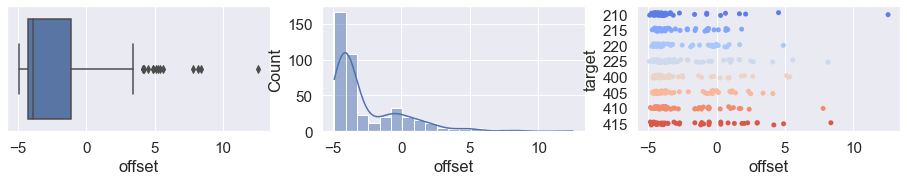

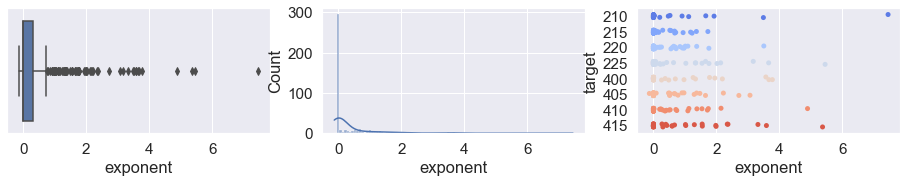

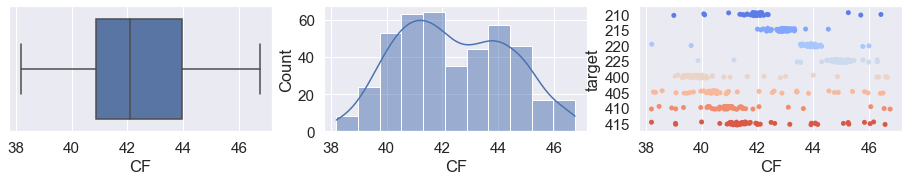

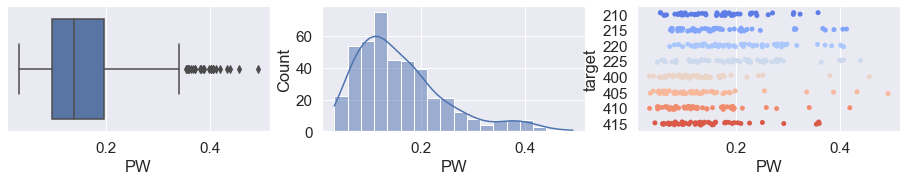

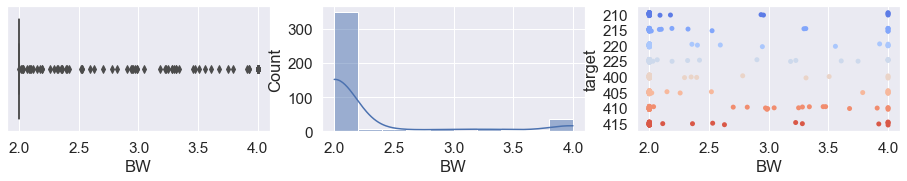

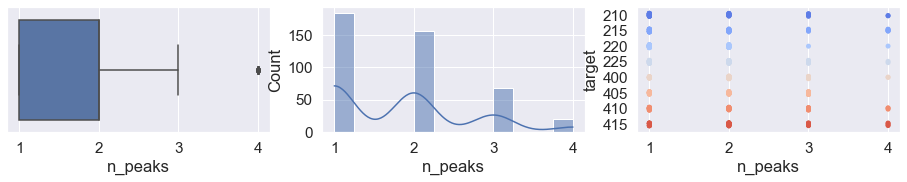

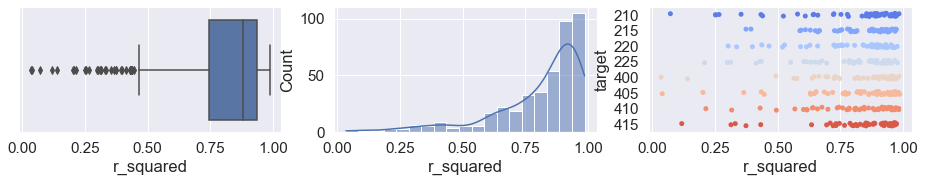

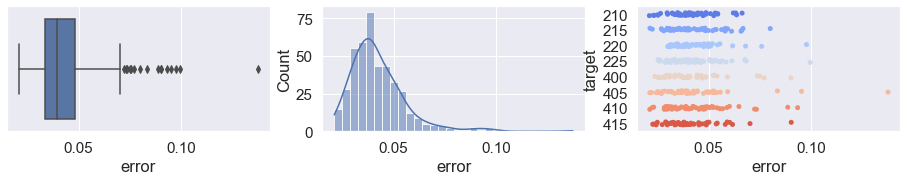

Done in 4.679s


In [11]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

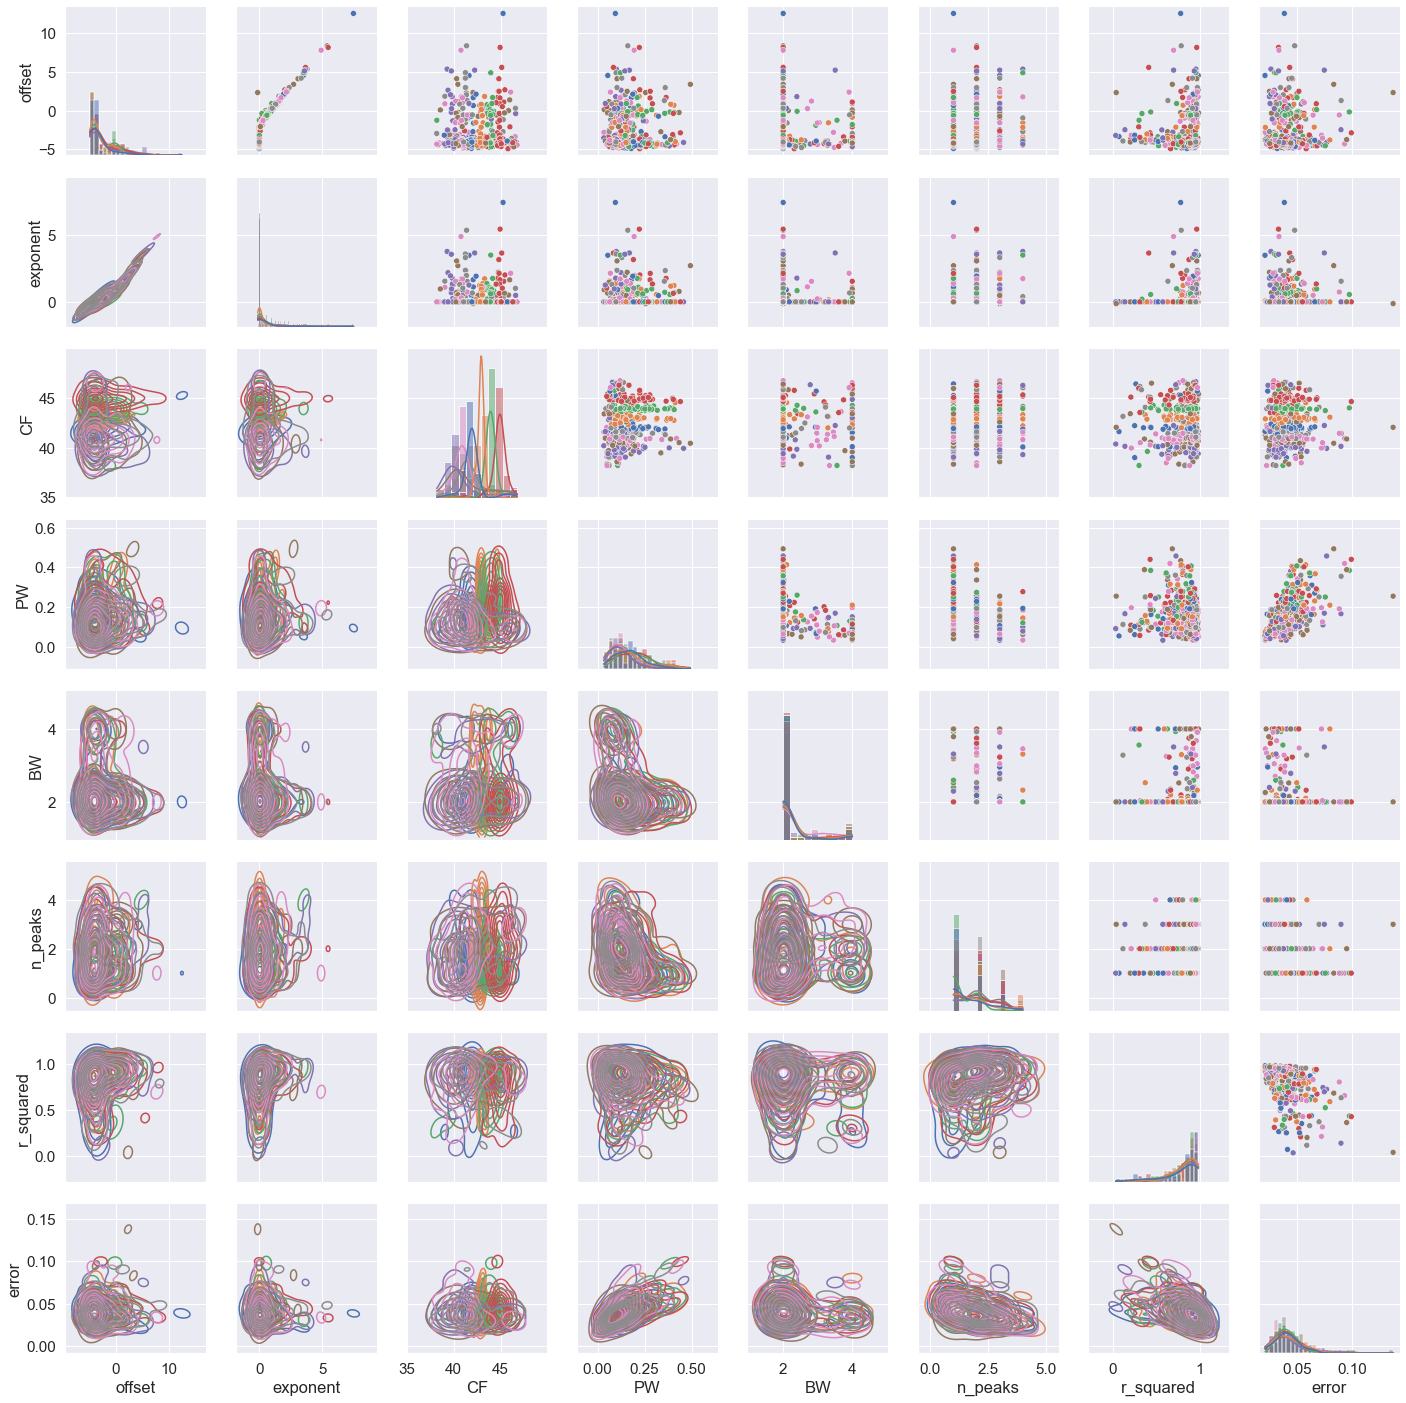

Done in 53.247s


In [12]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

offset  knee  exponent    CF    PW    BW  n_peaks  r_squared  error
offset       1.00  0.28      0.93  0.02  0.04 -0.06     0.11       0.16   0.01
knee         0.28  1.00      0.38  0.07 -0.04 -0.02    -0.05      -0.01  -0.01
exponent     0.93  0.38      1.00  0.01  0.03 -0.08     0.07       0.18  -0.04
CF           0.02  0.07      0.01  1.00  0.14  0.07     0.07      -0.04   0.00
PW           0.04 -0.04      0.03  0.14  1.00 -0.32    -0.37      -0.08   0.56
BW          -0.06 -0.02     -0.08  0.07 -0.32  1.00     0.03      -0.06  -0.16
n_peaks      0.11 -0.05      0.07  0.07 -0.37  0.03     1.00       0.12  -0.31
r_squared    0.16 -0.01      0.18 -0.04 -0.08 -0.06     0.12       1.00  -0.46
error        0.01 -0.01     -0.04  0.00  0.56 -0.16    -0.31      -0.46   1.00

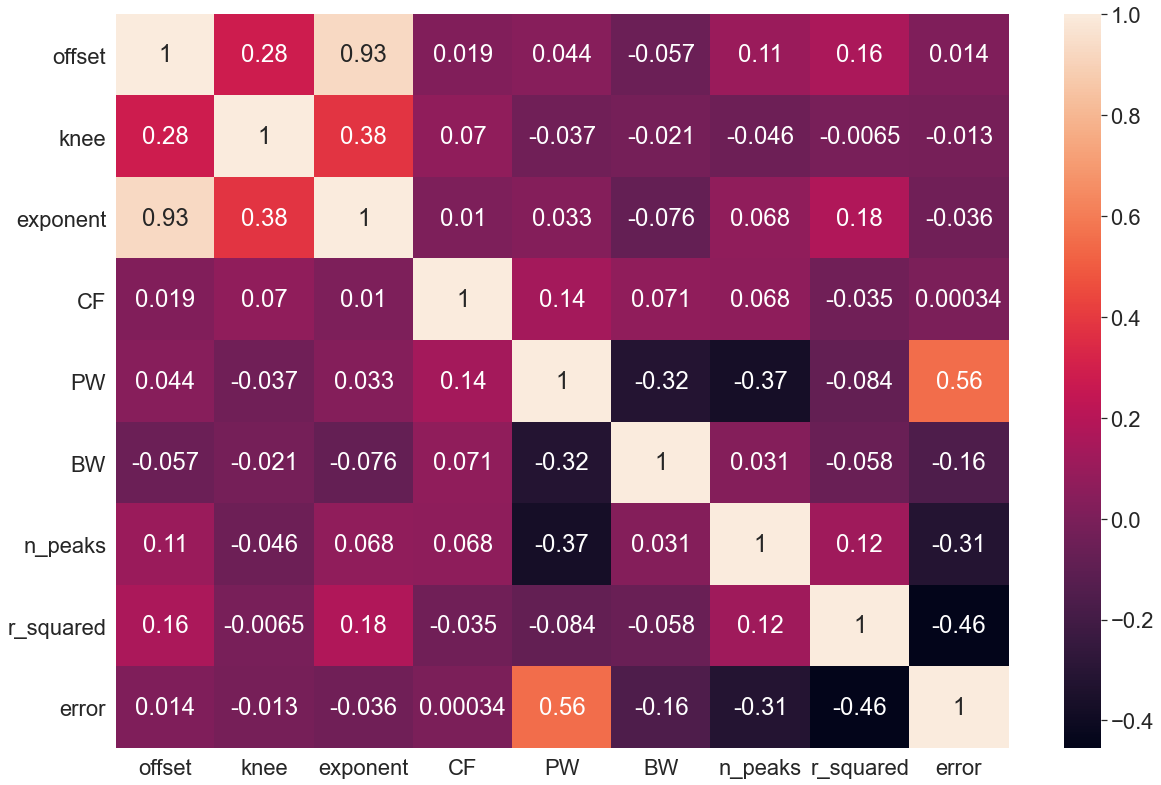

In [13]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [14]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

Feature: 0, Score: -1.15441
Feature: 1, Score: -44.79620
Feature: 2, Score: 1.00224
Feature: 3, Score: -0.35008
Feature: 4, Score: 0.26517
Feature: 5, Score: 0.00228
Feature: 6, Score: -0.06288
Feature: 7, Score: -0.45941
Feature: 8, Score: -0.51463


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


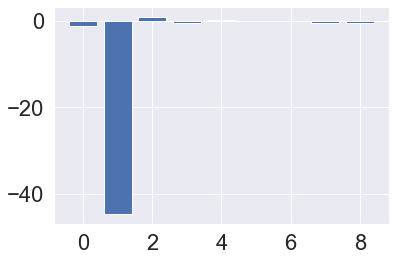

              precision    recall  f1-score   support

         210       0.20      0.25      0.22         8
         215       0.10      0.20      0.13         5
         220       0.55      0.43      0.48        14
         225       0.58      0.44      0.50        16
         400       0.33      0.21      0.26        14
         405       0.09      0.12      0.11         8
         410       0.25      0.33      0.29         9
         415       0.36      0.33      0.35        12

    accuracy                           0.31        86
   macro avg       0.31      0.29      0.29        86
weighted avg       0.36      0.31      0.33        86

Feature: 0, Score: -0.42142
Feature: 1, Score: 630.80666
Feature: 2, Score: 0.19898
Feature: 3, Score: -0.35155
Feature: 4, Score: 0.02489
Feature: 5, Score: -0.05319
Feature: 6, Score: -0.36391
Feature: 7, Score: -0.24259
Feature: 8, Score: -0.28051


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


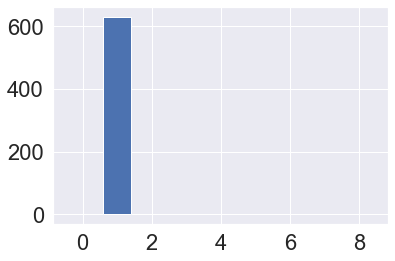

              precision    recall  f1-score   support

         210       0.40      0.24      0.30        17
         215       0.09      0.09      0.09        11
         220       0.45      0.38      0.42        13
         225       0.25      0.30      0.27        10
         400       0.56      0.36      0.43        14
         405       0.09      0.25      0.13         4
         410       0.36      0.31      0.33        13
         415       0.00      0.00      0.00         4

    accuracy                           0.27        86
   macro avg       0.28      0.24      0.25        86
weighted avg       0.34      0.27      0.29        86

Feature: 0, Score: -0.67566
Feature: 1, Score: 0.74677
Feature: 2, Score: 0.57135
Feature: 3, Score: -0.35911
Feature: 4, Score: 0.13527
Feature: 5, Score: -0.14014
Feature: 6, Score: -0.24920
Feature: 7, Score: -0.18742
Feature: 8, Score: -0.36528


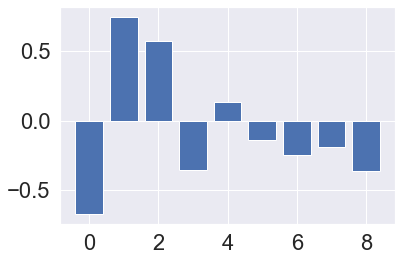

              precision    recall  f1-score   support

         210       0.40      0.36      0.38        11
         215       0.18      0.33      0.24         6
         220       0.55      0.55      0.55        11
         225       0.64      0.39      0.48        18
         400       0.30      0.43      0.35         7
         405       0.09      0.10      0.10        10
         410       0.27      0.17      0.21        18
         415       0.09      0.20      0.13         5

    accuracy                           0.31        86
   macro avg       0.31      0.32      0.30        86
weighted avg       0.36      0.31      0.33        86

Feature: 0, Score: -0.50675
Feature: 1, Score: 0.63260
Feature: 2, Score: 0.41516
Feature: 3, Score: -0.48799
Feature: 4, Score: 0.40523
Feature: 5, Score: -0.04336
Feature: 6, Score: -0.13124
Feature: 7, Score: -0.24614
Feature: 8, Score: -0.53808


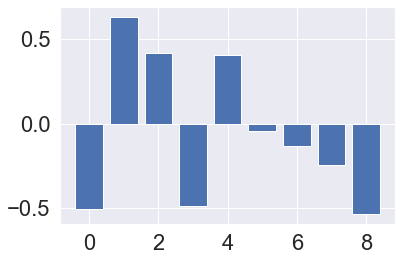

              precision    recall  f1-score   support

         210       0.36      0.29      0.32        14
         215       0.20      0.40      0.27         5
         220       0.73      0.73      0.73        11
         225       0.64      0.54      0.58        13
         400       0.10      0.14      0.12         7
         405       0.20      0.11      0.14        19
         410       0.18      0.22      0.20         9
         415       0.09      0.14      0.11         7

    accuracy                           0.32        85
   macro avg       0.31      0.32      0.31        85
weighted avg       0.34      0.32      0.32        85

Feature: 0, Score: -0.61535
Feature: 1, Score: 0.68924
Feature: 2, Score: 0.24228
Feature: 3, Score: -0.18555
Feature: 4, Score: 0.37045
Feature: 5, Score: -0.18478
Feature: 6, Score: -0.09630
Feature: 7, Score: -0.22707
Feature: 8, Score: -0.54052


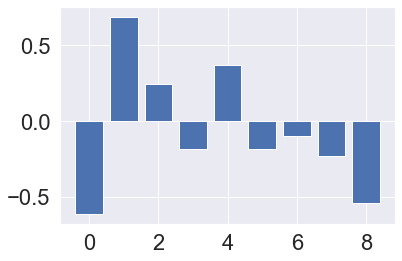

              precision    recall  f1-score   support

         210       0.10      0.12      0.11         8
         215       0.00      0.00      0.00         5
         220       0.73      0.36      0.48        22
         225       0.55      0.60      0.57        10
         400       0.40      0.36      0.38        11
         405       0.10      0.25      0.14         4
         410       0.17      0.14      0.15        14
         415       0.27      0.27      0.27        11

    accuracy                           0.29        85
   macro avg       0.29      0.26      0.26        85
weighted avg       0.38      0.29      0.32        85



In [15]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [16]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

VIF
offset               7.8
knee                 1.3
exponent             8.3
center of frequency  1.1
power                1.9
bandwidth            1.2
n peaks              1.3
R2                   1.4
MAE                  2.0

## 2. Ridge classifier

Feature: 0, Score: -0.07226
Feature: 1, Score: -0.00219
Feature: 2, Score: 0.02030
Feature: 3, Score: -0.05029
Feature: 4, Score: 0.03097
Feature: 5, Score: -0.01108
Feature: 6, Score: -0.02516
Feature: 7, Score: -0.07569
Feature: 8, Score: -0.06729


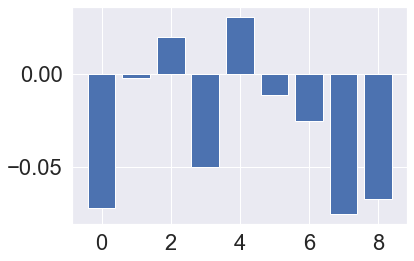

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.00      0.00      0.00         4
         215       0.00      0.00      0.00         0
         220       0.36      0.27      0.31        15
         225       0.83      0.38      0.53        26
         400       0.22      0.13      0.17        15
         405       0.00      0.00      0.00         4
         410       0.33      0.22      0.27        18
         415       0.09      0.25      0.13         4

    accuracy                           0.24        86
   macro avg       0.23      0.16      0.18        86
weighted avg       0.43      0.24      0.30        86

Feature: 0, Score: -0.00751

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Feature: 1, Score: 0.02345
Feature: 2, Score: -0.00045
Feature: 3, Score: -0.01169
Feature: 4, Score: -0.00170
Feature: 5, Score: -0.00332
Feature: 6, Score: -0.01990
Feature: 7, Score: -0.01144
Feature: 8, Score: -0.00515


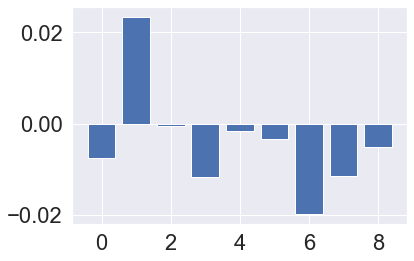

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.10      0.50      0.17         2
         215       0.00      0.00      0.00         0
         220       0.36      0.25      0.30        16
         225       0.67      0.33      0.44        24
         400       0.00      0.00      0.00         0
         405       0.00      0.00      0.00         0
         410       0.91      0.24      0.38        42
         415       0.00      0.00      0.00         2

    accuracy                           0.27        86
   macro avg       0.25      0.17      0.16        86
weighted avg       0.70      0.27      0.37        86

Feature: 0, Score: -0.00633
Feature: 1, Score: 0.02328
Feature: 2, Score: 0.00162
Feature: 3, Score: -0.01136
Feature: 4, Score: 0.00362
Feature: 5, Score: -0.00668
Feature: 6, Score: -0.01644
Feature: 7, Score: -0.00677
Feature: 8, Score: -0.00566


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


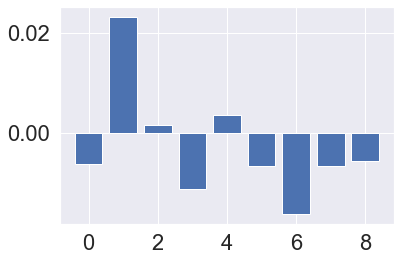

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.00      0.00      0.00         0
         215       0.00      0.00      0.00         0
         220       0.18      0.18      0.18        11
         225       0.91      0.29      0.43        35
         400       0.00      0.00      0.00         0
         405       0.00      0.00      0.00         0
         410       0.55      0.20      0.29        30
         415       0.18      0.20      0.19        10

    accuracy                           0.23        86
   macro avg       0.23      0.11      0.14        86
weighted avg       0.60      0.23      0.32        86

Feature: 0, Score: -0.00530
Feature: 1, Score: 0.02344
Feature: 2, Score: 0.00121
Feature: 3, Score: -0.01341
Feature: 4, Score: 0.00924
Feature: 5, Score: -0.00816
Feature: 6, Score: -0.01240
Feature: 7, Score: -0.00417
Feature: 8, Score: -0.00706

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


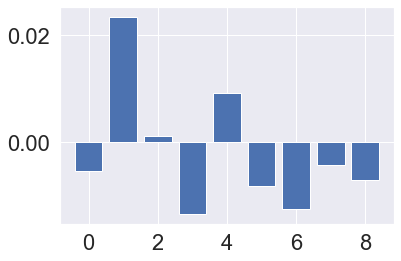

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.00      0.00      0.00         0
         215       0.00      0.00      0.00         0
         220       0.55      0.38      0.44        16
         225       0.91      0.37      0.53        27
         400       0.00      0.00      0.00         0
         405       0.00      0.00      0.00         2
         410       1.00      0.30      0.46        37
         415       0.00      0.00      0.00         3

    accuracy                           0.32        85
   macro avg       0.31      0.13      0.18        85
weighted avg       0.83      0.32      0.45        85

Feature: 0, Score: -0.11488
Feature: 1, Score: 0.11453
Feature: 2, Score: 0.04383
Feature: 3, Score: -0.04365
Feature: 4, Score: 0.06319
Feature: 5, Score: -0.03654
Feature: 6, Score: -0.02223
Feature: 7, Score: -0.04908
Feature: 8, Score: -0.08923


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


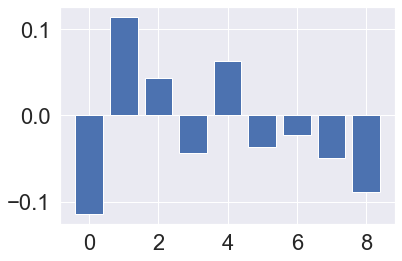

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         210       0.10      0.17      0.12         6
         215       0.00      0.00      0.00         0
         220       0.55      0.32      0.40        19
         225       0.73      0.42      0.53        19
         400       0.10      0.25      0.14         4
         405       0.10      0.50      0.17         2
         410       0.58      0.27      0.37        26
         415       0.18      0.22      0.20         9

    accuracy                           0.31        85
   macro avg       0.29      0.27      0.24        85
weighted avg       0.50      0.31      0.36        85



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.03023
Feature: 1, Score: -0.00233
Feature: 2, Score: 0.00930
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


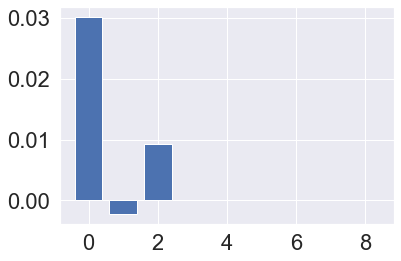

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.30      0.27      0.29        11
         215       0.50      0.38      0.43        13
         220       0.36      0.40      0.38        10
         225       0.58      0.58      0.58        12
         400       0.33      0.33      0.33         9
         405       0.18      0.22      0.20         9
         410       0.25      0.43      0.32         7
         415       0.27      0.20      0.23        15

    accuracy                           0.35        86
   macro avg       0.35      0.35      0.35        86
weighted avg       0.36      0.35      0.35        86

Feature: 0, Score: 0.00233
Feature: 1, Score: 0.00233
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00233
Feature: 4, Score: -0.01163
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00465


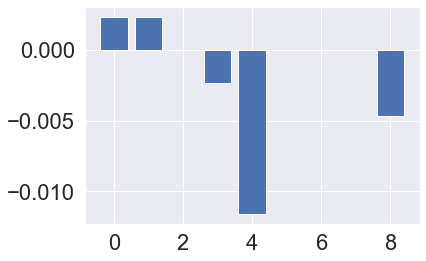

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.40      0.44      0.42         9
         215       0.45      0.45      0.45        11
         220       0.27      0.25      0.26        12
         225       0.42      0.50      0.45        10
         400       0.11      0.12      0.12         8
         405       0.27      0.27      0.27        11
         410       0.27      0.20      0.23        15
         415       0.09      0.10      0.10        10

    accuracy                           0.29        86
   macro avg       0.29      0.29      0.29        86
weighted avg       0.29      0.29      0.29        86

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00465
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


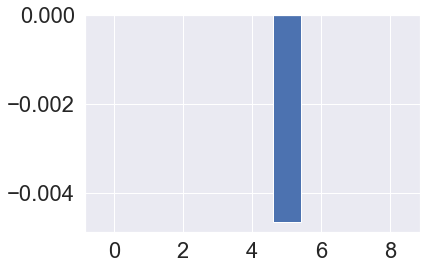

n_neighbors: 11
              precision    recall  f1-score   support

         210       0.60      0.40      0.48        15
         215       0.45      0.45      0.45        11
         220       0.45      0.42      0.43        12
         225       0.45      0.38      0.42        13
         400       0.10      0.20      0.13         5
         405       0.09      0.17      0.12         6
         410       0.27      0.27      0.27        11
         415       0.09      0.08      0.08        13

    accuracy                           0.31        86
   macro avg       0.31      0.30      0.30        86
weighted avg       0.36      0.31      0.33        86

Feature: 0, Score: -0.00706
Feature: 1, Score: 0.00235
Feature: 2, Score: 0.00941
Feature: 3, Score: -0.03059
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00706
Feature: 7, Score: 0.02118
Feature: 8, Score: 0.00000


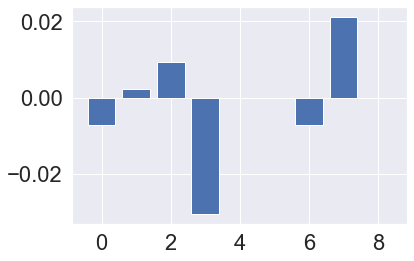

n_neighbors: 7
              precision    recall  f1-score   support

         210       0.45      0.26      0.33        19
         215       0.30      0.17      0.21        18
         220       0.55      0.60      0.57        10
         225       0.36      0.40      0.38        10
         400       0.30      0.75      0.43         4
         405       0.00      0.00      0.00         8
         410       0.27      0.38      0.32         8
         415       0.09      0.12      0.11         8

    accuracy                           0.29        85
   macro avg       0.29      0.33      0.29        85
weighted avg       0.32      0.29      0.29        85

Feature: 0, Score: -0.01176
Feature: 1, Score: -0.00235
Feature: 2, Score: -0.00941
Feature: 3, Score: -0.00235
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: -0.00235
Feature: 8, Score: 0.00000


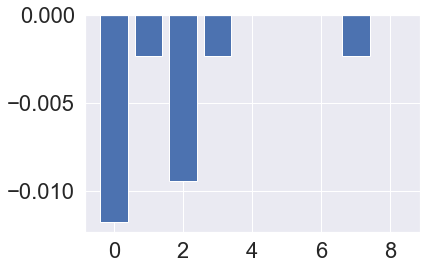

n_neighbors: 17
              precision    recall  f1-score   support

         210       0.50      0.36      0.42        14
         215       0.20      0.18      0.19        11
         220       0.73      0.33      0.46        24
         225       0.27      0.75      0.40         4
         400       0.30      0.30      0.30        10
         405       0.00      0.00      0.00         4
         410       0.17      0.22      0.19         9
         415       0.18      0.22      0.20         9

    accuracy                           0.29        85
   macro avg       0.29      0.30      0.27        85
weighted avg       0.40      0.29      0.32        85



In [18]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [19]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.80      0.73      0.76        11
         215       0.70      0.70      0.70        10
         220       0.45      0.71      0.56         7
         225       0.75      0.56      0.64        16
         400       0.11      0.14      0.12         7
         405       0.27      0.33      0.30         9
         410       0.33      0.44      0.38         9
         415       0.45      0.29      0.36        17

    accuracy                           0.49        86
   macro avg       0.48      0.49      0.48        86
weighted avg       0.52      0.49      0.50        86

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.70      1.00      0.82         7
         215       0.73      0.80      0.76        10
         220       0.64      0.88      0.74         8
         225       0.58      0.70      0.64     

## 5. Random forest

Feature: 0, Score: 0.07422
Feature: 1, Score: 0.07944
Feature: 2, Score: 0.08298
Feature: 3, Score: 0.41781
Feature: 4, Score: 0.10410
Feature: 5, Score: 0.03508
Feature: 6, Score: 0.03881
Feature: 7, Score: 0.08283
Feature: 8, Score: 0.08473


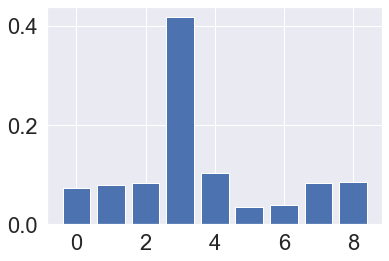

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.65      0.72      0.68        18
         215       0.86      0.75      0.80        24
         220       0.82      0.82      0.82        22
         225       0.61      0.58      0.60        24
         400       0.80      0.67      0.73        24
         405       0.41      0.53      0.46        17
         410       0.55      0.50      0.52        24
         415       0.38      0.44      0.41        18

    accuracy                           0.63       171
   macro avg       0.63      0.63      0.63       171
weighted avg       0.65      0.63      0.64       171

Feature: 0, Score: 0.07110
Feature: 1, Score: 0.06844
Feature: 2, Score: 0.07104
Feature: 3, Score: 0.47832
Feature: 4, Score: 0.09516
Feature: 5, Score: 0.03123
Feature: 6, Score: 0.03687
Feature: 7, Score: 0.07234
Feature: 8, Score: 0.07550


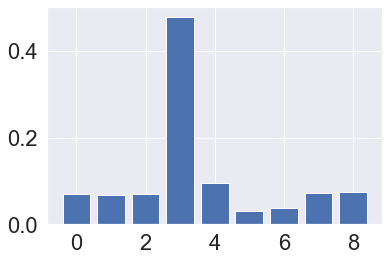

Number of trees: 200
Maximum depth: 10
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.52      0.79      0.63        14
         215       0.81      0.63      0.71        27
         220       0.86      0.79      0.83        24
         225       0.74      0.59      0.65        29
         400       0.40      0.40      0.40        20
         405       0.38      0.53      0.44        15
         410       0.45      0.50      0.48        20
         415       0.57      0.55      0.56        22

    accuracy                           0.60       171
   macro avg       0.59      0.60      0.59       171
weighted avg       0.62      0.60      0.60       171

Feature: 0, Score: 0.07731
Feature: 1, Score: 0.07785
Feature: 2, Score: 0.07501
Feature: 3, Score: 0.42176
Feature: 4, Score: 0.10599
Feature: 5, Score: 0.03152
Feature: 6, Score: 0.04000
Feature: 7, Score: 0.08519
Feature: 8, Score: 0.08538


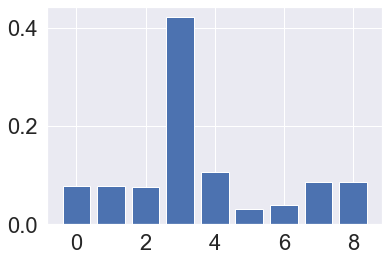

Number of trees: 1000
Maximum depth: 55
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.71      0.71      0.71        21
         215       0.86      0.82      0.84        22
         220       0.77      0.81      0.79        21
         225       0.83      0.73      0.78        26
         400       0.60      0.60      0.60        20
         405       0.52      0.41      0.46        27
         410       0.48      0.62      0.54        16
         415       0.45      0.56      0.50        18

    accuracy                           0.65       171
   macro avg       0.65      0.66      0.65       171
weighted avg       0.66      0.65      0.66       171

Feature: 0, Score: 0.07826
Feature: 1, Score: 0.07816
Feature: 2, Score: 0.07741
Feature: 3, Score: 0.42491
Feature: 4, Score: 0.10299
Feature: 5, Score: 0.03311
Feature: 6, Score: 0.03785
Feature: 7, Score: 0.08091
Feature: 8, Score: 0.08640


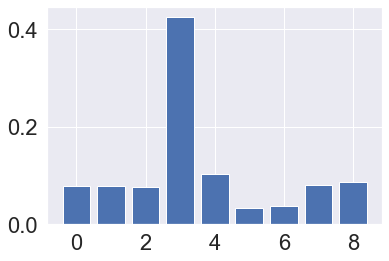

Number of trees: 2000
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.76      0.80      0.78        20
         215       0.76      0.70      0.73        23
         220       0.86      0.86      0.86        22
         225       0.91      0.68      0.78        31
         400       0.75      0.60      0.67        25
         405       0.33      0.50      0.40        14
         410       0.52      0.55      0.54        20
         415       0.50      0.69      0.58        16

    accuracy                           0.68       171
   macro avg       0.68      0.67      0.67       171
weighted avg       0.71      0.68      0.69       171

Feature: 0, Score: 0.07703
Feature: 1, Score: 0.07781
Feature: 2, Score: 0.07817
Feature: 3, Score: 0.42161
Feature: 4, Score: 0.10347
Feature: 5, Score: 0.03519
Feature: 6, Score: 0.03889
Feature: 7, Score: 0.08346
Feature: 8, Score: 0.08438


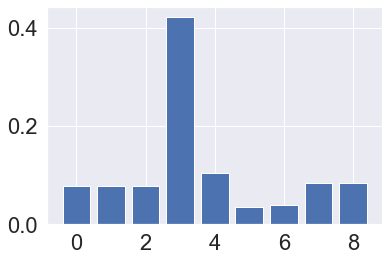

Number of trees: 1000
Maximum depth: 55
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.71      0.88      0.79        17
         215       0.73      0.94      0.82        17
         220       0.82      0.86      0.84        21
         225       0.95      0.62      0.75        34
         400       0.80      0.62      0.70        26
         405       0.41      0.60      0.49        15
         410       0.57      0.60      0.59        20
         415       0.57      0.57      0.57        21

    accuracy                           0.70       171
   macro avg       0.70      0.71      0.69       171
weighted avg       0.73      0.70      0.70       171

Done in 1684.1807296276093 seconds


In [33]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)  
    
print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [20]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [21]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_215, powers_220, powers_225, \
                                     powers_400, powers_405, powers_410, powers_415), \
                                    (210, 215, 220, 225, \
                                     400, 405, 410, 415)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 30 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -2.5861, -0.9866, -0.0015                                     
                                                              

# IV. Classification
## Assign variables

In [22]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

Feature: 0, Score: -1.27986
Feature: 1, Score: -0.04289
Feature: 2, Score: 1.47897
Feature: 3, Score: -0.10825
Feature: 4, Score: 0.20985
Feature: 5, Score: -0.00725
Feature: 6, Score: -0.22905
Feature: 7, Score: -0.32819
Feature: 8, Score: -0.36662


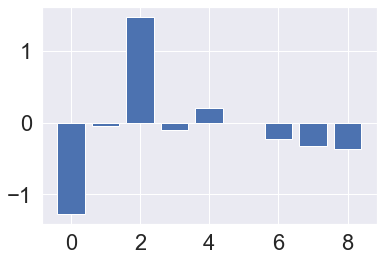

              precision    recall  f1-score   support

         210       0.35      0.24      0.29        29
         215       0.19      0.29      0.23        14
         220       0.55      0.60      0.57        20
         225       0.78      0.51      0.62        35
         400       0.20      0.20      0.20        20
         405       0.05      0.07      0.06        14
         410       0.18      0.17      0.17        24
         415       0.14      0.20      0.17        15

    accuracy                           0.31       171
   macro avg       0.30      0.28      0.29       171
weighted avg       0.36      0.31      0.33       171

Feature: 0, Score: -0.77200
Feature: 1, Score: -142.01231
Feature: 2, Score: 0.78665
Feature: 3, Score: -0.18365
Feature: 4, Score: 0.13999
Feature: 5, Score: -0.02614
Feature: 6, Score: -0.26794
Feature: 7, Score: -0.20947
Feature: 8, Score: -0.44351


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


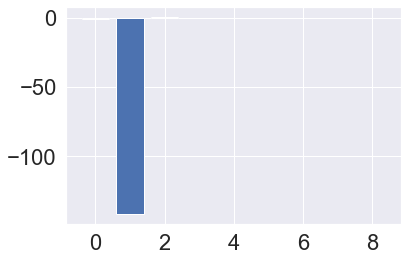

              precision    recall  f1-score   support

         210       0.29      0.30      0.29        20
         215       0.10      0.20      0.13        10
         220       0.59      0.43      0.50        30
         225       0.39      0.36      0.37        25
         400       0.15      0.13      0.14        23
         405       0.00      0.00      0.00        26
         410       0.23      0.20      0.21        25
         415       0.05      0.08      0.06        12

    accuracy                           0.23       171
   macro avg       0.22      0.21      0.21       171
weighted avg       0.26      0.23      0.24       171

Feature: 0, Score: -0.80313
Feature: 1, Score: -0.02969
Feature: 2, Score: 0.97783
Feature: 3, Score: -0.04045
Feature: 4, Score: 0.10197
Feature: 5, Score: -0.10732
Feature: 6, Score: -0.25182
Feature: 7, Score: -0.39783
Feature: 8, Score: -0.43085


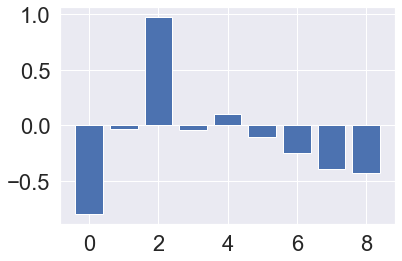

              precision    recall  f1-score   support

         210       0.33      0.33      0.33        21
         215       0.52      0.39      0.45        28
         220       0.59      0.48      0.53        27
         225       0.61      0.54      0.57        26
         400       0.35      0.25      0.29        28
         405       0.14      0.23      0.18        13
         410       0.33      0.28      0.30        25
         415       0.05      0.33      0.08         3

    accuracy                           0.37       171
   macro avg       0.37      0.36      0.34       171
weighted avg       0.43      0.37      0.39       171

Feature: 0, Score: -0.54322
Feature: 1, Score: -0.05574
Feature: 2, Score: 0.77716
Feature: 3, Score: -0.10868
Feature: 4, Score: -0.02988
Feature: 5, Score: -0.09552
Feature: 6, Score: -0.23176
Feature: 7, Score: -0.20915
Feature: 8, Score: -0.18820


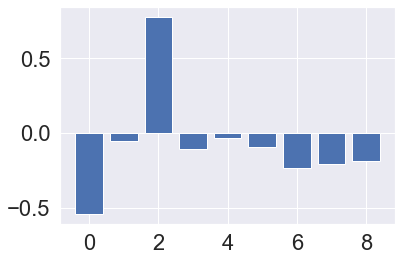

              precision    recall  f1-score   support

         210       0.57      0.55      0.56        22
         215       0.29      0.33      0.31        18
         220       0.64      0.50      0.56        28
         225       0.52      0.43      0.47        28
         400       0.15      0.21      0.18        14
         405       0.19      0.21      0.20        19
         410       0.38      0.29      0.33        28
         415       0.14      0.21      0.17        14

    accuracy                           0.36       171
   macro avg       0.36      0.34      0.35       171
weighted avg       0.40      0.36      0.38       171

Feature: 0, Score: -1.08669
Feature: 1, Score: -0.05858
Feature: 2, Score: 1.34054
Feature: 3, Score: -0.12800
Feature: 4, Score: 0.07709
Feature: 5, Score: -0.14784
Feature: 6, Score: -0.20730
Feature: 7, Score: -0.36163
Feature: 8, Score: -0.49568


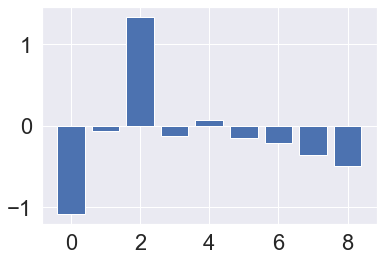

              precision    recall  f1-score   support

         210       0.48      0.32      0.38        31
         215       0.09      0.25      0.13         8
         220       0.50      0.35      0.42        31
         225       0.36      0.26      0.30        31
         400       0.15      0.23      0.18        13
         405       0.00      0.00      0.00        11
         410       0.33      0.21      0.25        34
         415       0.10      0.17      0.12        12

    accuracy                           0.25       171
   macro avg       0.25      0.22      0.22       171
weighted avg       0.33      0.25      0.28       171



In [23]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 


In [24]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

VIF
offset               7.7
knee                 1.3
exponent             8.5
center of frequency  1.1
power                2.0
bandwidth            1.1
n peaks              1.1
R2                   1.5
MAE                  2.2

## 2. Ridge classifier

Feature: 0, Score: -0.22290
Feature: 1, Score: -0.03431
Feature: 2, Score: 0.22828
Feature: 3, Score: -0.02247
Feature: 4, Score: 0.03819
Feature: 5, Score: -0.00979
Feature: 6, Score: -0.05681
Feature: 7, Score: -0.07051
Feature: 8, Score: -0.07249


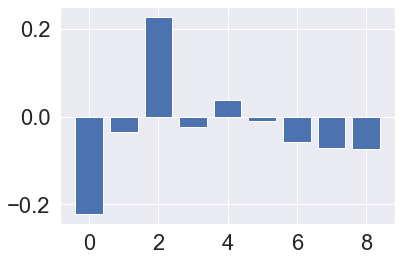

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         210       0.25      0.25      0.25        20
         215       0.00      0.00      0.00         0
         220       0.32      0.33      0.33        21
         225       0.91      0.38      0.53        56
         400       0.15      0.14      0.14        22
         405       0.00      0.00      0.00        11
         410       0.27      0.15      0.20        39
         415       0.05      0.50      0.09         2

    accuracy                           0.25       171
   macro avg       0.24      0.22      0.19       171
weighted avg       0.45      0.25      0.31       171

Feature: 0, Score: -0.13164
Feature: 1, Score: -0.00732
Feature: 2, Score: 0.09262
Feature: 3, Score: -0.02902
Feature: 4, Score: 0.03255
Feature: 5, Score: -0.00770
Feature: 6, Score: -0.06612
Feature: 7, Score: -0.03985
Feature: 8, Score: -0.08576


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


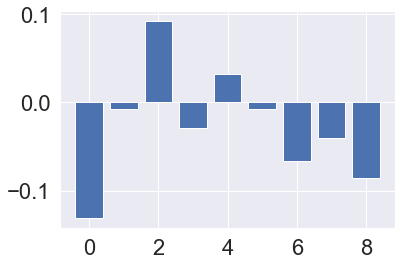

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         210       0.24      0.38      0.29        13
         215       0.00      0.00      0.00         1
         220       0.45      0.28      0.34        36
         225       0.52      0.30      0.38        40
         400       0.20      0.13      0.16        30
         405       0.05      0.06      0.05        16
         410       0.23      0.16      0.19        31
         415       0.00      0.00      0.00         4

    accuracy                           0.22       171
   macro avg       0.21      0.16      0.18       171
weighted avg       0.32      0.22      0.25       171

Feature: 0, Score: -0.07096
Feature: 1, Score: -0.01183
Feature: 2, Score: 0.06946
Feature: 3, Score: -0.01113
Feature: 4, Score: 0.00400
Feature: 5, Score: -0.02830
Feature: 6, Score: -0.06170
Feature: 7, Score: -0.07732
Feature: 8, Score: -0.07333


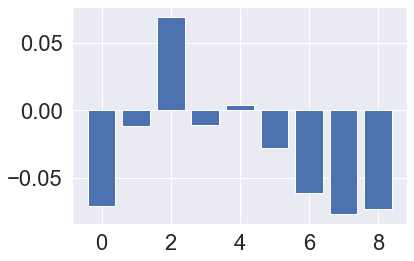

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.05      0.09      0.06        11
         215       0.10      0.67      0.17         3
         220       0.27      0.23      0.25        26
         225       0.83      0.35      0.49        55
         400       0.35      0.19      0.25        37
         405       0.05      0.25      0.08         4
         410       0.33      0.23      0.27        31
         415       0.05      0.25      0.08         4

    accuracy                           0.26       171
   macro avg       0.25      0.28      0.20       171
weighted avg       0.45      0.26      0.31       171

Feature: 0, Score: -0.04233
Feature: 1, Score: -0.01448
Feature: 2, Score: 0.05562
Feature: 3, Score: -0.01414
Feature: 4, Score: -0.00894
Feature: 5, Score: -0.02546
Feature: 6, Score: -0.05673
Feature: 7, Score: -0.03828
Feature: 8, Score: -0.03875


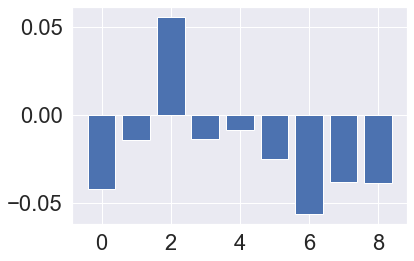

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.19      0.50      0.28         8
         215       0.14      0.60      0.23         5
         220       0.59      0.33      0.42        40
         225       0.57      0.28      0.38        46
         400       0.10      0.17      0.12        12
         405       0.10      0.25      0.14         8
         410       0.57      0.24      0.34        49
         415       0.05      0.33      0.08         3

    accuracy                           0.29       171
   macro avg       0.29      0.34      0.25       171
weighted avg       0.48      0.29      0.33       171

Feature: 0, Score: -0.17096
Feature: 1, Score: -0.04150
Feature: 2, Score: 0.19849
Feature: 3, Score: -0.02417
Feature: 4, Score: 0.01160
Feature: 5, Score: -0.03593
Feature: 6, Score: -0.04952
Feature: 7, Score: -0.07638
Feature: 8, Score: -0.09449


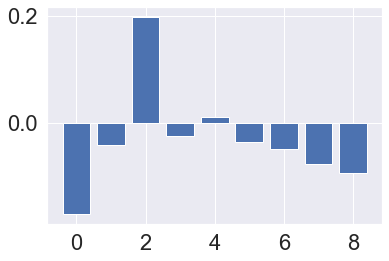

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         210       0.24      0.42      0.30        12
         215       0.05      0.50      0.08         2
         220       0.36      0.21      0.26        39
         225       0.59      0.27      0.37        49
         400       0.10      0.18      0.13        11
         405       0.00      0.00      0.00         7
         410       0.52      0.23      0.32        47
         415       0.10      0.50      0.16         4

    accuracy                           0.25       171
   macro avg       0.24      0.29      0.20       171
weighted avg       0.42      0.25      0.29       171



In [25]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.02339
Feature: 1, Score: 0.00117
Feature: 2, Score: 0.00468
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


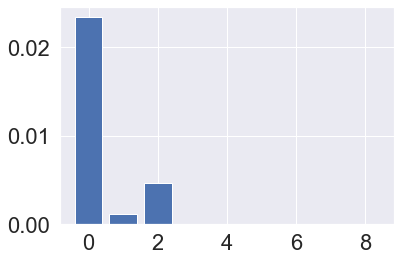

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.50      0.45      0.48        22
         215       0.52      0.52      0.52        21
         220       0.55      0.52      0.53        23
         225       0.43      0.43      0.43        23
         400       0.25      0.38      0.30        13
         405       0.23      0.22      0.22        23
         410       0.27      0.30      0.29        20
         415       0.29      0.23      0.26        26

    accuracy                           0.38       171
   macro avg       0.38      0.38      0.38       171
weighted avg       0.39      0.38      0.38       171

Feature: 0, Score: -0.02105
Feature: 1, Score: 0.00819
Feature: 2, Score: 0.00468
Feature: 3, Score: 0.00585
Feature: 4, Score: 0.00234
Feature: 5, Score: -0.00117
Feature: 6, Score: 0.00702
Feature: 7, Score: 0.00351
Feature: 8, Score: 0.00000


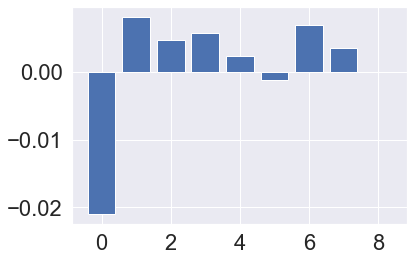

n_neighbors: 4
              precision    recall  f1-score   support

         210       0.48      0.25      0.33        40
         215       0.33      0.23      0.27        30
         220       0.36      0.33      0.35        24
         225       0.35      0.42      0.38        19
         400       0.20      0.22      0.21        18
         405       0.24      0.36      0.29        14
         410       0.18      0.29      0.22        14
         415       0.29      0.50      0.36        12

    accuracy                           0.30       171
   macro avg       0.30      0.33      0.30       171
weighted avg       0.34      0.30      0.31       171

Feature: 0, Score: 0.00117
Feature: 1, Score: 0.00702
Feature: 2, Score: 0.00234
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00117
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


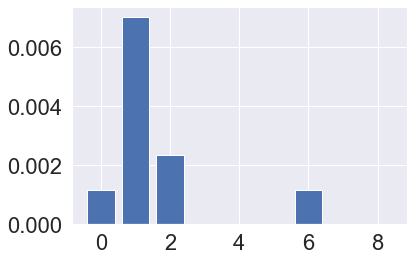

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.43      0.33      0.38        27
         215       0.43      0.41      0.42        22
         220       0.45      0.37      0.41        27
         225       0.39      0.45      0.42        20
         400       0.15      0.27      0.19        11
         405       0.29      0.25      0.27        24
         410       0.29      0.27      0.28        22
         415       0.27      0.33      0.30        18

    accuracy                           0.34       171
   macro avg       0.34      0.34      0.33       171
weighted avg       0.36      0.34      0.34       171

Feature: 0, Score: -0.00234
Feature: 1, Score: 0.00585
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00234
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00585
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


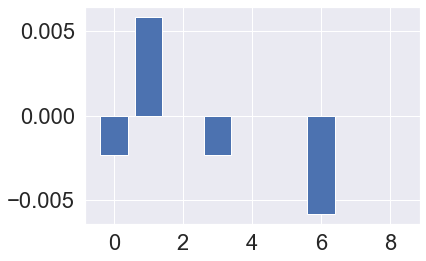

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.52      0.52      0.52        21
         215       0.52      0.55      0.54        20
         220       0.55      0.48      0.51        25
         225       0.52      0.50      0.51        24
         400       0.45      0.50      0.47        18
         405       0.24      0.36      0.29        14
         410       0.43      0.45      0.44        20
         415       0.32      0.24      0.27        29

    accuracy                           0.44       171
   macro avg       0.44      0.45      0.44       171
weighted avg       0.45      0.44      0.44       171

Feature: 0, Score: 0.01637
Feature: 1, Score: 0.01053
Feature: 2, Score: 0.00819
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00117
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


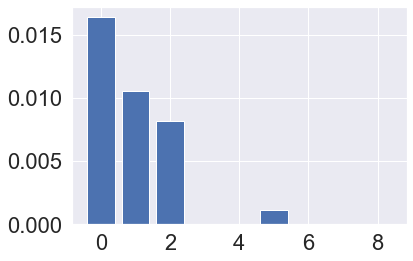

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.57      0.57      0.57        21
         215       0.55      0.60      0.57        20
         220       0.41      0.36      0.38        25
         225       0.45      0.40      0.43        25
         400       0.20      0.27      0.23        15
         405       0.32      0.33      0.33        21
         410       0.43      0.36      0.39        25
         415       0.38      0.42      0.40        19

    accuracy                           0.42       171
   macro avg       0.41      0.41      0.41       171
weighted avg       0.42      0.42      0.42       171



In [26]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [27]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.60      0.60      0.60        20
         215       0.71      0.68      0.70        22
         220       0.73      0.64      0.68        25
         225       0.43      0.67      0.53        15
         400       0.35      0.37      0.36        19
         405       0.18      0.20      0.19        20
         410       0.55      0.39      0.45        31
         415       0.38      0.42      0.40        19

    accuracy                           0.49       171
   macro avg       0.49      0.50      0.49       171
weighted avg       0.51      0.49      0.49       171



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.48      0.71      0.57        14
         215       0.71      0.83      0.77        18
         220       0.73      0.73      0.73        22
         225       0.65      0.60      0.63        25
         400       0.40      0.47      0.43        17
         405       0.43      0.38      0.40        24
         410       0.55      0.40      0.46        30
         415       0.43      0.43      0.43        21

    accuracy                           0.55       171
   macro avg       0.55      0.57      0.55       171
weighted avg       0.55      0.55      0.55       171



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.76      0.64      0.70        25
         215       0.76      0.73      0.74        22
         220       0.64      0.70      0.67        20
         225       0.61      0.56      0.58        25
         400       0.20      0.25      0.22        16
         405       0.29      0.25      0.27        24
         410       0.29      0.32      0.30        19
         415       0.23      0.25      0.24        20

    accuracy                           0.47       171
   macro avg       0.47      0.46      0.46       171
weighted avg       0.49      0.47      0.48       171



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.76      0.73      0.74        22
         215       0.76      0.76      0.76        21
         220       0.64      0.74      0.68        19
         225       0.83      0.51      0.63        37
         400       0.50      0.40      0.44        25
         405       0.29      0.32      0.30        19
         410       0.29      0.55      0.37        11
         415       0.50      0.65      0.56        17

    accuracy                           0.57       171
   macro avg       0.57      0.58      0.56       171
weighted avg       0.61      0.57      0.58       171

Activation function: tanh
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.86      0.67      0.75        27
         215       0.45      0.71      0.56        14
         220       0.64      0.70      0.67        20
         225       0.64      0.54      0.58     

## 5. Random forest

Feature: 0, Score: 0.07672
Feature: 1, Score: 0.07995
Feature: 2, Score: 0.08155
Feature: 3, Score: 0.41388
Feature: 4, Score: 0.10429
Feature: 5, Score: 0.03580
Feature: 6, Score: 0.03762
Feature: 7, Score: 0.08384
Feature: 8, Score: 0.08636


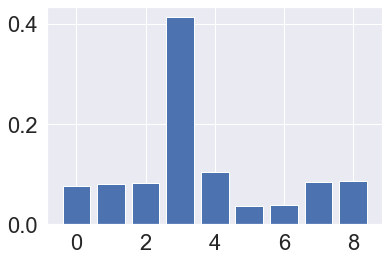

Number of trees: 1000
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.65      0.72      0.68        18
         215       0.90      0.73      0.81        26
         220       0.82      0.82      0.82        22
         225       0.61      0.58      0.60        24
         400       0.80      0.67      0.73        24
         405       0.36      0.57      0.44        14
         410       0.59      0.43      0.50        30
         415       0.29      0.46      0.35        13

    accuracy                           0.63       171
   macro avg       0.63      0.62      0.62       171
weighted avg       0.66      0.63      0.64       171

Feature: 0, Score: 0.07624
Feature: 1, Score: 0.07355
Feature: 2, Score: 0.07378
Feature: 3, Score: 0.44397
Feature: 4, Score: 0.10022
Feature: 5, Score: 0.03300
Feature: 6, Score: 0.03687
Feature: 7, Score: 0.07808
Feature: 8, Score: 0.08429


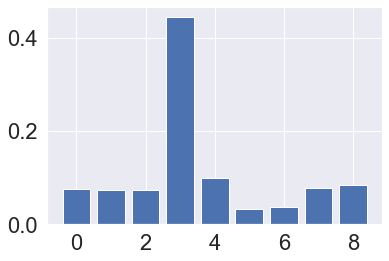

Number of trees: 200
Maximum depth: 32
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.52      0.73      0.61        15
         215       0.76      0.62      0.68        26
         220       0.86      0.76      0.81        25
         225       0.74      0.59      0.65        29
         400       0.35      0.39      0.37        18
         405       0.29      0.40      0.33        15
         410       0.45      0.43      0.44        23
         415       0.52      0.55      0.54        20

    accuracy                           0.57       171
   macro avg       0.56      0.56      0.55       171
weighted avg       0.60      0.57      0.58       171

Feature: 0, Score: 0.07731
Feature: 1, Score: 0.07785
Feature: 2, Score: 0.07501
Feature: 3, Score: 0.42176
Feature: 4, Score: 0.10599
Feature: 5, Score: 0.03152
Feature: 6, Score: 0.04000
Feature: 7, Score: 0.08519
Feature: 8, Score: 0.08538


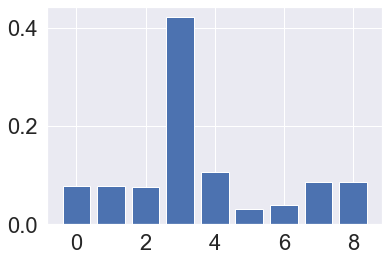

Number of trees: 1000
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.71      0.71      0.71        21
         215       0.86      0.82      0.84        22
         220       0.77      0.81      0.79        21
         225       0.83      0.73      0.78        26
         400       0.60      0.60      0.60        20
         405       0.52      0.41      0.46        27
         410       0.48      0.62      0.54        16
         415       0.45      0.56      0.50        18

    accuracy                           0.65       171
   macro avg       0.65      0.66      0.65       171
weighted avg       0.66      0.65      0.66       171

Feature: 0, Score: 0.07749
Feature: 1, Score: 0.07767
Feature: 2, Score: 0.07715
Feature: 3, Score: 0.42572
Feature: 4, Score: 0.10340
Feature: 5, Score: 0.03312
Feature: 6, Score: 0.03745
Feature: 7, Score: 0.08158
Feature: 8, Score: 0.08642


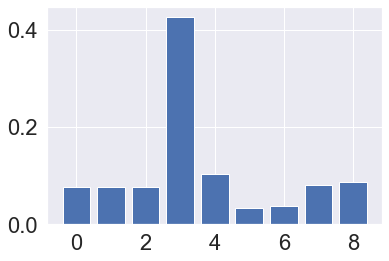

Number of trees: 1000
Maximum depth: 77
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.76      0.80      0.78        20
         215       0.76      0.70      0.73        23
         220       0.86      0.86      0.86        22
         225       0.91      0.66      0.76        32
         400       0.75      0.60      0.67        25
         405       0.33      0.54      0.41        13
         410       0.52      0.55      0.54        20
         415       0.50      0.69      0.58        16

    accuracy                           0.68       171
   macro avg       0.68      0.67      0.67       171
weighted avg       0.72      0.68      0.69       171

Feature: 0, Score: 0.07745
Feature: 1, Score: 0.07813
Feature: 2, Score: 0.07849
Feature: 3, Score: 0.41880
Feature: 4, Score: 0.10362
Feature: 5, Score: 0.03507
Feature: 6, Score: 0.03879
Feature: 7, Score: 0.08418
Feature: 8, Score: 0.08545


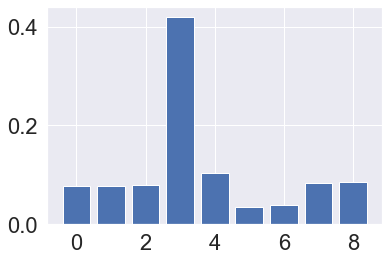

Number of trees: 2000
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.71      0.88      0.79        17
         215       0.73      0.94      0.82        17
         220       0.82      0.86      0.84        21
         225       0.95      0.60      0.74        35
         400       0.75      0.60      0.67        25
         405       0.41      0.60      0.49        15
         410       0.57      0.60      0.59        20
         415       0.57      0.57      0.57        21

    accuracy                           0.69       171
   macro avg       0.69      0.71      0.69       171
weighted avg       0.72      0.69      0.69       171

Done in 1340.4121301174164 seconds


In [37]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   
    
print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [34]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table7.csv')
performance.to_csv('performance_table7.csv')

# Display
display(performance)
display(df)

accuracy  precision  recall classifier n_channels table
0       0.31       0.36    0.31        log         13     7
1       0.27       0.34    0.27        log         13     7
2       0.31       0.36    0.31        log         13     7
3       0.32       0.34    0.32        log         13     7
4       0.29       0.38    0.29        log         13     7
5       0.24       0.43    0.24      ridge         13     7
6       0.27       0.70    0.27      ridge         13     7
7       0.23       0.60    0.23      ridge         13     7
8       0.32       0.83    0.32      ridge         13     7
9       0.31       0.50    0.31      ridge         13     7
10      0.35       0.36    0.35        KNN         13     7
11      0.29       0.29    0.29        KNN         13     7
12      0.31       0.36    0.31        KNN         13     7
13      0.29       0.32    0.29        KNN         13     7
14      0.29       0.40    0.29        KNN         13     7
15      0.49       0.52    0.49        MLP         13     7
16      0.57       0.55    0.57        MLP         13     7
17      0.49       0.50    0.49        MLP         13     7
18      0.49       0.51    0.49        MLP         13     7
19      0.52       0.60    0.52        MLP         13     7
20      0.31       0.36    0.31        log          3     7
21      0.23       0.26    0.23        log          3     7
22      0.37       0.43    0.37        log          3     7
23      0.36       0.40    0.36        log          3     7
24      0.25       0.33    0.25        log          3     7
25      0.25       0.45    0.25      ridge          3     7
26      0.22       0.32    0.22      ridge          3     7
27      0.26       0.45    0.26      ridge          3     7
28      0.29       0.48    0.29      ridge          3     7
29      0.25       0.42    0.25      ridge          3     7
30      0.38       0.39    0.38        KNN          3     7
31      0.30       0.34    0.30        KNN          3     7
32      0.34       0.36    0.34        KNN          3     7
33      0.44       0.45    0.44        KNN          3     7
34      0.42       0.42    0.42        KNN          3     7
35      0.49       0.51    0.49        MLP          3     7
36      0.55       0.55    0.55        MLP          3     7
37      0.47       0.49    0.47        MLP          3     7
38      0.57       0.61    0.57        MLP          3     7
39      0.52       0.54    0.52        MLP          3     7
40      0.63       0.67    0.63         RF          3     7
41      0.57       0.60    0.57         RF          3     7
42      0.67       0.68    0.67         RF          3     7
43      0.68       0.72    0.68         RF          3     7
44      0.67       0.71    0.67         RF          3     7
45      0.63       0.65    0.63         RF         13     7
46      0.60       0.62    0.60         RF         13     7
47      0.65       0.66    0.65         RF         13     7
48      0.68       0.71    0.68         RF         13     7
49      0.70       0.73    0.70         RF         13     7

subject    day target    offset       knee  exponent         CF        PW  \
0        S1  /Day1    220 -4.075655  -1.001271  0.000507  44.255100  0.182455   
1        S1  /Day1    225 -3.626586  -1.001425  0.000782  45.094704  0.108520   
2        S1  /Day1    400 -4.241769  -1.001322  0.000485  40.789368  0.144279   
3        S1  /Day1    405 -4.220107  -1.001587  0.000558  40.508125  0.133994   
4        S1  /Day2    210 -3.477522  -1.001307  0.000714  46.418179  0.099473   
..      ...    ...    ...       ...        ...       ...        ...       ...   
850     S30  /Day2    225 -3.938260  -1.001699  0.000525  45.013027  0.274082   
851     S30  /Day2    400 -3.832783  -1.001861  0.000591  39.412014  0.066667   
852     S30  /Day2    405 -3.641878  -1.003031  0.000956  41.725098  0.076044   
853     S30  /Day2    410 -1.455021  -1.367692  0.100159  40.811443  0.072712   
854     S30  /Day2    415  1.649376 -30.336967  1.308630  40.964329  0.118595   

           BW  n_peaks  r_squared     error  
0    2.000000        1   0.465229  0.046365  
1    2.000000        2   0.208260  0.053383  
2    2.350276        1   0.663628  0.039957  
3    2.000000        2   0.699494  0.038891  
4    4.000000        1   0.265923  0.033503  
..        ...      ...        ...       ...  
850  2.000000        1   0.827701  0.055005  
851  2.000000        1   0.848437  0.044143  
852  3.271244        2   0.875139  0.033721  
853  2.000000        3   0.907861  0.035224  
854  2.000000        3   0.937749  0.028484  

[855 rows x 12 columns]

In [35]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.376     0.392  0.376
           13            0.306     0.346  0.306
MLP        3             0.520     0.540  0.520
           13            0.512     0.536  0.512
RF         3             0.644     0.676  0.644
           13            0.652     0.674  0.652
log        3             0.304     0.356  0.304
           13            0.300     0.356  0.300
ridge      3             0.254     0.424  0.254
           13            0.274     0.612  0.274

log 13


accuracy     0.008000
precision    0.006693
recall       0.008000
dtype: float64

log 3


accuracy     0.025235
precision    0.026321
recall       0.025235
dtype: float64

Ridge 13


accuracy     0.016149
precision    0.063586
recall       0.016149
dtype: float64

Ridge 3


accuracy     0.010040
precision    0.024755
recall       0.010040
dtype: float64

KNN 13


accuracy     0.010431
precision    0.016876
recall       0.010431
dtype: float64

KNN 3


accuracy     0.022909
precision    0.017754
recall       0.022909
dtype: float64

MLP 13


accuracy     0.013971
precision    0.016149
recall       0.013971
dtype: float64

MLP 3


accuracy     0.016492
precision    0.018330
recall       0.016492
dtype: float64

RF 13


accuracy     0.015849
precision    0.018022
recall       0.015849
dtype: float64

RF 3


accuracy     0.018243
precision    0.018889
recall       0.018243
dtype: float64

In [36]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

sum_sq    df           F        PR(>F)
C(classifier)                1.055328   4.0  153.658722  1.040874e-23
C(n_channels)                0.001458   1.0    0.849156  3.623160e-01
C(classifier):C(n_channels)  0.012152   4.0    1.769366  1.540739e-01
Residual                     0.068680  40.0         NaN           NaN

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.175  0.001  0.1207  0.2293   True
   KNN     RF    0.307  0.001  0.2527  0.3613   True
   KNN    log   -0.039 0.2645 -0.0933  0.0153  False
   KNN  ridge   -0.077 0.0019 -0.1313 -0.0227   True
   MLP     RF    0.132  0.001  0.0777  0.1863   True
   MLP    log   -0.214  0.001 -0.2683 -0.1597   True
   MLP  ridge   -0.252  0.001 -0.3063 -0.1977   True
    RF    log   -0.346  0.001 -0.4003 -0.2917   True
    RF  ridge   -0.384  0.001 -0.4383 -0.3297   True
   log  ridge   -0.038 0.2889 -0.0923  0.0163  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3     13  -0.0108 0.8119 -0.0983 0.0767  False
--------------------------------------------------

sum_sq    df          F        PR(>F)
C(classifier)                0.699028   4.0  38.450387  3.320651e-13
C(n_channels)                0.009248   1.0   2.034764  1.614971e-01
C(classifier):C(n_channels)  0.084452   4.0   4.645325  3.564006e-03
Residual                     0.181800  40.0        NaN           NaN

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.169  0.001  0.0696  0.2684   True
   KNN     RF    0.306  0.001  0.2066  0.4054   True
   KNN    log   -0.013    0.9 -0.1124  0.0864  False
   KNN  ridge    0.149  0.001  0.0496  0.2484   True
   MLP     RF    0.137 0.0027  0.0376  0.2364   True
   MLP    log   -0.182  0.001 -0.2814 -0.0826   True
   MLP  ridge    -0.02    0.9 -0.1194  0.0794  False
    RF    log   -0.319  0.001 -0.4184 -0.2196   True
    RF  ridge   -0.157  0.001 -0.2564 -0.0576   True
   log  ridge    0.162  0.001  0.0626  0.2614   True
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3     13   0.0272 0.5011 -0.0534 0.1078  False
--------------------------------------------------

sum_sq    df           F        PR(>F)
C(classifier)                1.055328   4.0  153.658722  1.040874e-23
C(n_channels)                0.001458   1.0    0.849156  3.623160e-01
C(classifier):C(n_channels)  0.012152   4.0    1.769366  1.540739e-01
Residual                     0.068680  40.0         NaN           NaN

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.175  0.001  0.1207  0.2293   True
   KNN     RF    0.307  0.001  0.2527  0.3613   True
   KNN    log   -0.039 0.2645 -0.0933  0.0153  False
   KNN  ridge   -0.077 0.0019 -0.1313 -0.0227   True
   MLP     RF    0.132  0.001  0.0777  0.1863   True
   MLP    log   -0.214  0.001 -0.2683 -0.1597   True
   MLP  ridge   -0.252  0.001 -0.3063 -0.1977   True
    RF    log   -0.346  0.001 -0.4003 -0.2917   True
    RF  ridge   -0.384  0.001 -0.4383 -0.3297   True
   log  ridge   -0.038 0.2889 -0.0923  0.0163  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3     13  -0.0108 0.8119 -0.0983 0.0767  False
--------------------------------------------------